# Experiments - PyMC, PyStan and TFP

In this notebook we compare three probabilistic programming libraries (PyStan, PyMC and TFP) over the Palmer Penguins dataset.

## 0. Set-up

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc as pm
import arviz as az
import stan 
import time

import nest_asyncio
nest_asyncio.apply()
del nest_asyncio

In [3]:
penguins = pd.read_csv("penguins.csv")
penguins.head()

,rowid,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,1,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,2,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,3,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,4,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,5,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [4]:
penguins = penguins.copy()[['species',
                        'bill_length_mm',
                        'bill_depth_mm',
                        'flipper_length_mm',
                        'body_mass_g']]
                        
penguins.dropna(inplace=True)
penguins.head()

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


In [5]:
y_s = pd.Categorical(penguins['species']).codes
N = len(y_s)
x_n = penguins.columns[1:]
x_s = penguins[x_n].values
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)

In [6]:
x_s.shape, y_s.shape, N

((342, 4), (342,), 342)

In [7]:
data = {                                                                                             
    'N': N,                                                                                        
    'K': 4,                                                                                        
    'y': y_s,                                                                                     
    'X': x_s                                                                                             
}  

### sklearn

In [8]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x_s, y_s)
print(clf.score(x_s, y_s))

0.9912280701754386


In [11]:
clf.coef_

array([[-2.71878862,  1.53345391, -0.49370443,  0.37695774],
       [ 2.36596039,  0.23362757, -0.70838965, -1.53406293],
       [ 0.35282822, -1.76708147,  1.20209409,  1.15710519]])

In [12]:
clf.intercept_

array([ 0.55986555, -0.16453957, -0.39532598])

### Pymc

In [12]:
start_time = time.time()
with pm.Model() as model_s:
    alpha = pm.Normal('alpha', mu=0, sigma=10, shape=3)
    beta = pm.Normal('beta', mu=0, sigma=2, shape=(4,3))
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.math.softmax(mu)
    yl = pm.Categorical('yl', p=theta, observed=y_s)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_s = pm.sample(8000, step, start, tune=5000)
tot_time = time.time() - start_time
print("PyMC execution time: {}".format(tot_time))

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 5_000 tune and 8_000 draw iterations (10_000 + 16_000 draws total) took 1139 seconds.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.


PyMC execution time: 1166.7608442306519


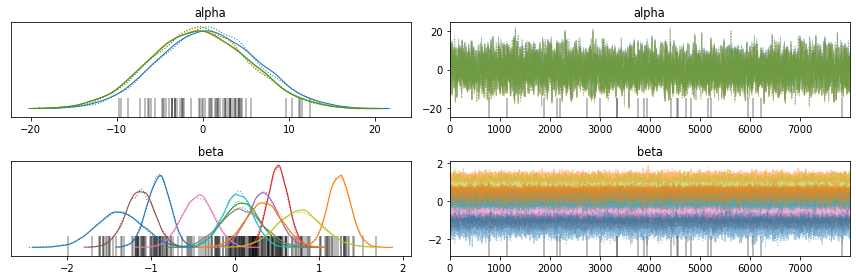

In [13]:
plots = az.plot_trace(trace_s, ['alpha','beta'])
plt.tight_layout()
plt.show()

### PyStan

In [29]:
code = """                                                                                         
data {                                                                                               
  int N; //the number observations                                                                                                                 
  int K; //the number of features                                                                    
  int y[N]; //the response                                                                           
  matrix[N,K] X; //the model matrix                                                                  
}                                                                                                    
parameters {                                                                                         
  real alpha;                                                                                        
  vector[K] beta; //the regression parameters                                                        
}                                                                                                    
transformed parameters {                                                                             
  vector[N] linpred;                                                                                 
  linpred = alpha+X*beta;                                                                            
}                                                                                                    
model {                                                                                              
  alpha ~ normal(0,10); //prior for the intercept following Gelman 2008                              
                                                                                                   
  for(i in 1:K)                                                                                      
    beta[i] ~ normal(0,10);                                                                 
                                                                                                   
  y ~ categorical_logit(linpred);                                                                      
}                                                                                                                                                                                                       
"""  

In [30]:
posterior = stan.build(code, data=data, random_seed=1)

Building: 0.5s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.2s
Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s
Building: 5.4s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s
Building: 7.2s
Building: 7.3s
Building: 7.4s
Building: 7.5s
Building: 7.6s
Building: 7.7s
Building: 7.8s
Building: 7.9s
Building: 8.0s
Building: 

In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:6:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:33:8: warning: unused variable 'error' [-Wunused-variable]
  bool error = false;
       ^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_matching_dims.hpp:57:23: warning: comparison of integers of different signs: 'int' and 'std:

Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.4s
Building: 12.5s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:50:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/hmm_check.hpp:33:7: warning: unused variable 'n_transitions' [-Wunused-variable]
  int n_transitions = log_omegas.cols() - 1;
      ^


Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 14.0s
Building: 14.1s
Building: 14.2s
Building: 14.3s
Building: 14.4s
Building: 14.6s
Building: 14.7s
Building: 14.8s
Building: 14.9s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:96:39: warning: lambda capture 'a' is not used [-Wunused-lambda-capture]
  return make_callback_var(beta_val, [a, b, digamma_ab](auto& vi) mutable

Building: 15.1s
Building: 15.2s
Building: 15.3s
Building: 15.4s
Building: 15.5s
Building: 15.6s
Building: 15.7s
Building: 15.8s
Building: 15.9s
Building: 16.1s
Building: 16.2s
Building: 16.3s
Building: 16.4s
Building: 16.5s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun.hpp:121:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/gp_matern52_cov.hpp:304:10: warning: unused variable 'neg_root_5' [-Wunused

Building: 16.6s
Building: 16.7s
Building: 16.9s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun.hpp:188:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/log_mix.hpp:86:13: warning: unused variable 'N' [-Wunused-variable]
  const

Building: 17.0s
Building: 17.1s
Building: 17.2s
Building: 17.3s
Building: 17.4s
Building: 17.5s
Building: 17.7s
Building: 17.8s
Building: 17.9s
Building: 18.0s
Building: 18.1s
Building: 18.2s
Building: 18.3s
Building: 18.5s
Building: 18.6s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:124:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/matrix_power.hpp:52:24: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'const int' [-Wsign-compare]
  for (size_t i = 2; i <= n; ++i) {
                     ~ ^  ~
In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_hea

Building: 18.7s
Building: 18.8s
Building: 18.9s
Building: 19.0s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:158:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/simplex_constrain.hpp:40:30: warning: comparison of integers of different signs: 'Eigen::Index' (aka 'long') and 'size_t' (aka 'unsigned long') [-Wsign-compare]
  for (Eigen::Index k = 0; k < N; ++k) {
                           ~ ^ ~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/simplex_constrain.hpp:94:30: warning: comparison of integers of different signs: 'Eigen::Index' (aka

Building: 19.1s
Building: 19.3s
Building: 19.4s
Building: 19.5s
Building: 19.6s
Building: 19.7s
Building: 19.8s
Building: 19.9s
Building: 20.1s
Building: 20.2s
Building: 20.3s
Building: 20.5s
Building: 20.6s
Building: 20.7s
Building: 20.8s
Building: 20.9s
Building: 21.0s
Building: 21.2s
Building: 21.3s
Building: 21.4s
Building: 21.5s
Building: 21.6s
Building: 21.7s
Building: 21.9s
Building: 22.0s
Building: 22.1s
Building: 22.2s
Building: 22.3s
Building: 22.4s
Building: 22.5s
Building: 22.7s
Building: 22.8s
Building: 22.9s
Building: 23.0s
Building: 23.1s
Building: 23.2s
Building: 23.3s
Building: 23.5s
Building: 23.6s
Building: 23.7s
Building: 23.8s
Building: 23.9s
Building: 24.0s
Building: 24.1s
Building: 24.3s
Building: 24.4s
Building: 24.5s
Building: 24.6s
Building: 24.7s
Building: 24.8s
Building: 24.9s
Building: 25.1s
Building: 25.2s
Building: 25.3s
Building: 25.4s
Building: 25.5s
Building: 25.6s
Building: 25.8s
Building: 25.9s
Building: 26.0s
Building: 26.1s
Building: 26.2s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:11:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/dae.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/idas_integrator.hpp:5:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/functor/idas_service.hpp:93:28: warning: comparison of integers of different signs: 'size_t' (aka 'unsigned long') and 'int' [-Wsign-compare]
    for (size_t is = 0; is < ns; +

Building: 26.3s
Building: 26.4s
Building: 26.6s
Building: 26.7s
Building: 26.8s
Building: 26.9s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:87:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/double_exponential_cdf.hpp:77:10: warning: unused variable 'N' [-Wunused-variable]
  size_t N = max_size(y, mu, sigma);
         ^


Building: 27.0s
Building: 27.2s
Building: 27.3s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:41:21: warning: comparison of integers of different signs: 'int' and 'size_t' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < M; i++) {
                  ~ ^ ~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7:

Building: 27.4s
Building: 27.5s
Building: 27.6s
Building: 27.7s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:139:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/hmm_marginal.hpp:26:13: warning: unused variable 'n_states' [-Wunused-variable]
  const int n_states = omegas.rows();
            ^


Building: 27.9s
Building: 28.0s
Building: 28.1s
Building: 28.2s
Building: 28.3s
Building: 28.5s
Building: 28.6s
Building: 28.7s
Building: 28.8s
Building: 28.9s
Building: 29.0s
Building: 29.2s
Building: 29.3s
Building: 29.4s
Building: 29.5s
Building: 29.6s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:13:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:308:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_lccdf.hpp:78:13: warning: unused variable 'size_sigma' [-Wunused-variable]
  const int size_sigma = stan::math::size(sigma);
            ^
In 

Building: 29.7s
Building: 29.9s
Building: 30.0s
Building: 30.1s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:7:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<double>::size_type' (aka 'unsigned long') [-Wsign-compare]
      for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
                                         ~~~~~~~~~ ^ ~~~~~~~~~~~~~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/io/dump.hpp:707:24: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
             real_iter < val_i->second.first.size();
             ~~~~~~~~~ ^ ~~~~~~~~~~~~~~~~~~~~~~~~~~
In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbc

Building: 30.2s
Building: 30.3s
Building: 30.4s
Building: 30.6s
Building: 30.7s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:17:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/indexing.hpp:6:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:274:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/indexing/assign.hpp:528:21: warning: comparison of integers of different signs: 'int' and 'std::__1::vector<int>::size_type' (aka 'unsigned long') [-Wsign-compare]
  for (int i = 0; i < col_idx.ns_.size(); ++i) {
                  ~ ^ ~~~~~~~~~~~~~~~~~~
/usr/local/lib/python3.9/site-packages/https

Building: 30.8s
Building: 30.9s
Building: 31.0s
Building: 31.1s
Building: 31.2s
Building: 31.4s
Building: 31.5s
Building: 31.6s
Building: 31.7s
Building: 31.8s
Building: 31.9s
Building: 32.1s
Building: 32.2s
Building: 32.3s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:29:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_divide_equal.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_division.hpp:14:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_subtraction.hpp:84:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += 

Building: 32.4s
Building: 32.5s
Building: 32.6s
Building: 32.7s
Building: 32.9s
Building: 33.0s
Building: 33.1s
Building: 33.2s
Building: 33.3s
Building: 33.4s
Building: 33.5s
Building: 33.7s
Building: 33.8s
Building: 33.9s
Building: 34.1s
Building: 34.2s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/grad_inc_beta.hpp:45:43: note: in instantiation of function template specialization 'stan::math::operator+<int, nullptr>' requested here
    gr

Building: 34.3s
Building: 34.4s
Building: 34.6s
Building: 34.7s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:28:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/operator_addition.hpp:80:21: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
      [avi = a.vi_, b](const auto& vi) mutable { avi->adj_ += vi.adj_; });
                    ^
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/trigamma.hpp:63:31: note: in instantiation of function template specialization 'stan::math::operator+<double, nullptr>' requested here
    val

Building: 34.8s
Building: 34.9s
Building: 35.0s
Building: 35.1s
Building: 35.3s
Building: 35.4s
Building: 35.5s
Building: 35.6s
Building: 35.7s
Building: 35.8s
Building: 36.0s
Building: 36.1s
Building: 36.2s
Building: 36.3s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5:
/usr/local/lib/python3.9

Building: 36.5s
Building: 36.6s
Building: 36.7s
Building: 36.8s
Building: 37.0s
Building: 37.1s
Building: 37.2s
Building: 37.3s
Building: 37.4s
Building: 37.6s
Building: 37.7s
Building: 37.8s
Building: 37.9s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:53:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/profiling.hpp:9:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_2F1_converges.hpp:5:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/prim/err/check_not_nan.hpp:5:
/usr/local/lib/python3.9

Building: 38.1s
Building: 38.2s
Building: 38.3s
Building: 38.4s


In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:58:
/usr/local/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/set_zero_all_adjoints.hpp:14:13: warning: 'static' function 'set_zero_all_adjoints' declared in header file should be declared 'static inline' [-Wunneeded-internal-declaration]
static void set_zero_all_adjoints() {
            ^
In file included from /Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.cpp:2:
In file included from /usr/local/lib/python3.9/site-packages/httpstan/inc

Building: 38.5s
Building: 38.7s
Building: 38.8s
Building: 38.9s
Building: 39.0s
Building: 39.1s
Building: 39.2s
Building: 39.3s
Building: 39.5s
Building: 39.6s
Building: 39.7s
Building: 39.8s
Building: 39.9s
Building: 40.0s
Building: 40.1s
Building: 40.3s
Building: 40.4s
Building: 40.5s
Building: 40.6s
Building: 40.7s
Building: 40.8s
Building: 40.9s
Building: 41.1s
Building: 41.2s
Building: 41.3s
Building: 41.4s
Building: 41.5s
Building: 41.6s
Building: 41.7s
Building: 41.9s
Building: 42.0s
Building: 42.1s
Building: 42.2s
Building: 42.3s
Building: 42.4s
Building: 42.6s
Building: 42.7s
Building: 42.8s
Building: 42.9s
Building: 43.0s
Building: 43.1s
Building: 43.3s
Building: 43.4s
Building: 43.5s
Building: 43.6s
Building: 43.7s
Building: 43.8s
Building: 43.9s
Building: 44.1s
Building: 44.2s
Building: 44.3s
Building: 44.4s
Building: 44.5s
Building: 44.6s
Building: 44.7s
Building: 44.9s
Building: 45.0s
Building: 45.1s
Building: 45.2s
Building: 45.3s
Building: 45.4s
Building: 45.6s
Building

62 warnings generated.


Building: 53.1s
Building: 53.2s
Building: 53.3s
Building: 53.4s
Building: 53.5s


ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/usr/local/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::Q2' from file 'build/temp.macosx-11-x86_64-3.9/Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.o' means the weak symbol cannot be overridden at runtime. This was likely caused by different translation units being compiled with different visibility settings.
ld: warning: direct access in function 'long double boost::math::detail::bessel_j0<long double>(long double)' from file '/usr/local/lib/python3.9/site-packages/httpstan/stan_services.o' to global weak symbol 'long double boost::math::detail::bessel_j0<long double>(long double)::P2' from file 'build/temp.macosx-11-x86_64-3.9/Users/claudiahm/Library/Caches/httpstan/4.7.2/models/l6hbcloz/model_l6hbcloz.o' means the weak symbol cannot

Messages from stanc:
Warning in '/var/folders/79/lndg0b5n2q3b40m_ty2kxlm40000gn/T/httpstan_vo2pzw9k/model_l6hbcloz.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


In [32]:
fit = posterior.sample(num_chains=2, num_samples=1000)

Sampling:   0%
Sampling: Initialization failed.


RuntimeError: Initialization failed.

In [ ]:
varnames = ['alpha', 'beta']
az.plot_trace(fit, varnames)
plt.tight_layout()
plt.show()